# COSC 526 - Project

---

Effects of climate change on global food production under SRES emissions and socio-economic scenarios

Data set developed by Ana Iglesias of Universidad Politecnica de Madrid and Cynthia Rosenzweig of the NASA Goddard Institute for Space Studies and disseminated by the NASA Socioeconomic Data and Applications Center (SEDAC), managed by CIESIN at Columbia University
March 2010
http://sedac.ciesin.columbia.edu/mva/cropclimate/

Data Description
In the coming decades the agricultural sector faces many challenges stemming from growing global populations, land degradation, and loss of cropland to urbanization. Although food production has been able to keep pace with population growth on the global scale, periodically there are serious regional deficits, and poverty related nutritional deficiencies affect close to a billion people globally. In this century climate change is one factor that could affect food production and availability in many parts of the world, particularly those most prone to drought and famine.

The purpose of this data set is to provide an assessment of potential climate change impacts on world staple crop production (wheat, rice, and maize) with a focus on quantitative estimates of yield changes based on multiple climate scenario runs. The data set assesses the implications of temperature and precipitation changes for world crop yields taking into account uncertainty in the level of climate change expected and physiological effects of carbon dioxide on plant growth. Adaptation is explicitly considered and incorporated into the results by assessing the country or regional potential for reaching optimal crop yield. Optimal yield is the potential yield non limited by water, fertilizer, and without management constraints. Adapted yields are evaluated in each country as a fraction of the potential yield. The weighting factor combines the ratio of current yields to current yield potential and the economic limitation of the economic country’s agricultural systems. 

The baseline year for crop yield changes is the average yield simulated under current climate (1970-2000 baseline). The resulting yield change data were then fed into trade models to assess impacts on prices and overall food production. (Please note that total production changes need to be treated with caution, since production is determined by many factors.)  The overall objective is to calculate quantitative estimates of climate change impacts on the amount of food produced globally, and to determine the consequences to world food prices and the number of people at risk of hunger.

This data set is an update to a major crop modeling study by the NASA Goddard Institute for Space Studies (GISS). The initial study was published in 1997, based on output of HadCM2 model forced with greenhouse gas concentration from the IS95 emission scenarios in 1997. Results of the initial study are presented at SEDAC's Potential Impacts of Climate Change on World Food Supply: Data Sets from a Major Crop Modeling Study, released in 2001. The co-authors developed and tested a method for investigating the spatial implications of climate change on crop production. The Decision Support System for Agrotechnology Transfer (DSSAT) dynamic process crop growth models, are specified and validated for one hundred and twenty seven sites in the major world agricultural regions. Results from the crop models, calibrated and validated in the major crop-growing regions, are then used to test functional forms describing the response of yield changes in the climate and environmental conditions. This updated version is based on HadCM3 model output along with GHG concentrations from the Special Report on Emissions Scenarios (SRES). The crop yield estimates incorporate some major improvements: 1) consistent crop simulation methodology and climate change scenarios; 2) weighting of model site results by contribution to regional and national, and rainfed and irrigated production; 3) quantitative foundation for estimation of physiological CO2 effects on crop yields; and 4) Adaptation is explicitly considered.

This work links biophysical and statistical models in a rigorous and testable methodology, based on current understanding of processes of crop growth and development. The validated site crop models are useful for simulating the range of conditions under which crops are grown in the world, and provide the means to estimate production functions when experimental field data are not available. The derived functions are appropriate for application in global environmental change studies because they incorporate responses to higher temperatures, changed hydrological regimes, and higher levels of atmospheric CO2. Variables explaining a significant proportion of simulated yield variance in the current climate are crop water (sum of precipitation and irrigation) and temperature during the growing season.

Data Set Citation
Iglesias, Ana, and Cynthia Rosenzweig. 2010.  Effects of Climate Change on Global Food Production under Special Report on Emissions Scenarios (SRES) Emissions and Socioeconomic Scenarios: Data from a Crop Modeling Study. Palisades, NY: Socioeconomic Data and Applications Center (SEDAC), Columbia University. Available at http://sedac.ciesin.columbia.edu/mva/cropclimate/ (date of download)

References
Parry, M.L., Fischer, C., Livermore, M., Rosenzweig, C., Iglesias, A., 1999. Climate change and world food security: a new assessment. Global Environmental Change 9, 51–67

Parry, M.L., Rosenzweig, C., Iglesias, A., Livermore, M., Fischer, C., 2004. Effect of climate change on global food production under SRES emissions and socio-economic scenarios. Global Environmental Change 14, 53–67

Rosenzweig, C., and A. Iglesias. 2001. Potential Impacts of Climate Change on World Food Supply: Data Sets from a Major Crop Modeling Study, Palisades, NY: Socioeconomic Data and Applications Center, Columbia University.  Available at http://sedac.ciesin.columbia.edu/giss_crop_study/index.html 

Rosenzweig, C., M. L. Parry, G. Fischer, and K. Frohberg. 1993. Climate change and world food supply. Research Report No. 3. Oxford: University of Oxford, Environmental Change Unit. 


# Data Dictionary


In [1]:
# Import pandas and pyplot.
import pandas as pd
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from pyspark.mllib.clustering import KMeans

In [2]:
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 12,
        }

In [3]:
dataDF = pd.read_excel('crops-yield-changes-hadcm3-sres.xls',sheet_name=' Data sheet')
dataDF = dataDF.drop(165)#Dropping the last row of headers
# dataDF = dataDF.fillna(0)
# print(dataDF.iloc[1, 0])
features = [colName for colName in dataDF.columns]#Getting the features of the data
Year = [2020,2050,2080]
Scenarios = ['A1F', 'A2a', 'A2b', 'A2c', 'B1a', 'B2a', 'B2b']
length = len(Year)
# print(features[0])

In [4]:
#Grouping of three crops
def make_TripletData(dataFrame,scenario,year,process):
    col1 = 'WH'+scenario+year
    col2 = 'RI'+scenario+year
    col3 = 'MZ'+scenario+year
    countryName = dataFrame[features[0]]
    x0 = dataFrame[col1]
    x1 = dataFrame[col2]
    x2 = dataFrame[col3]
    
    if(process=='drop'):
        x0_new = x0.dropna()
        x1_new = x1.dropna()
        x2_new = x2.dropna()
    elif(process=='fillWithZero'):
        x0_new = x0.fillna(0)
        x1_new = x1.fillna(0)
        x2_new = x2.fillna(0)

    
    array = np.zeros([dataFrame.shape[0],3])
    for i in range(0,dataFrame.shape[0]):
        array[i][0] = x0_new[i]
        array[i][1] = x1_new[i]
        array[i][2] = x2_new[i]
        
    tup = [(countryName[i],array[i,:]) for i in range(0,dataFrame.shape[0])]
  
    
    return tup

In [5]:
def make_TripletDataRDD(dataFrame,scenario,year,process):  
    RDD = sc.parallelize(make_TripletData(dataFrame,scenario,year,process))
    return RDD     

In [6]:
#Grouping of three years
def groupYears(scenario):
    data2020RDD = make_TripletDataRDD(dataDF,scenario,year='2020',process='fillWithZero')
    data2050RDD = make_TripletDataRDD(dataDF,scenario,year='2050',process='fillWithZero')
    data2080RDD = make_TripletDataRDD(dataDF,scenario,year='2080',process='fillWithZero')
    
    return data2020RDD,data2050RDD,data2080RDD

In [24]:
###Scenario###
groupTest = groupYears(scenario=Scenarios[0])#Scenarios A1F, A2a, A2b, A2c, B1a, B2a, B2b
groupTest_values = []
for i in range(0,length):
    groupTest_values.append(groupTest[i].map(lambda x: x[1]))
testData = groupTest[0]
testData_values = groupTest_values[0]

print(testData.take(1))

[('Afghanistan', array([-1.21628737, -3.21628737, -5.53940013]))]


# K-Means

---

Clustering using K-means

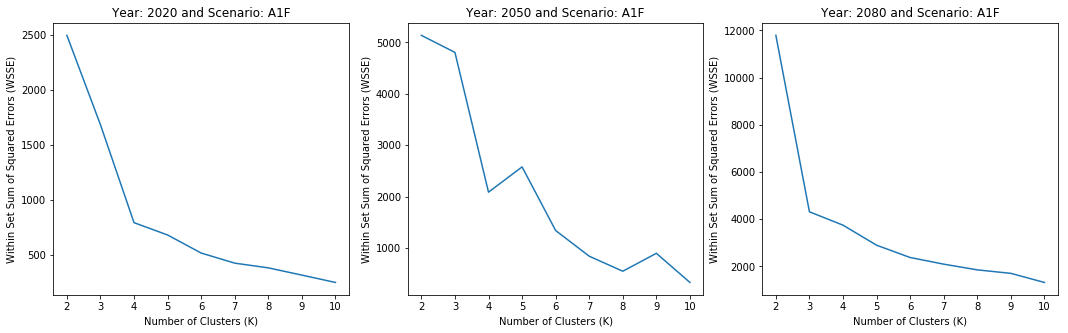

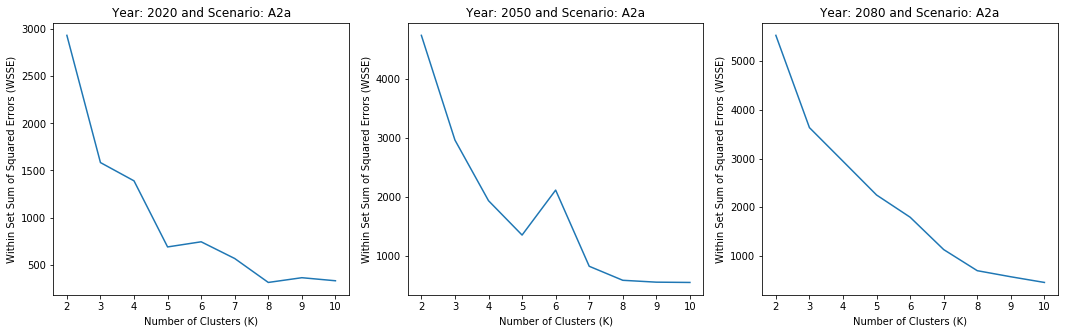

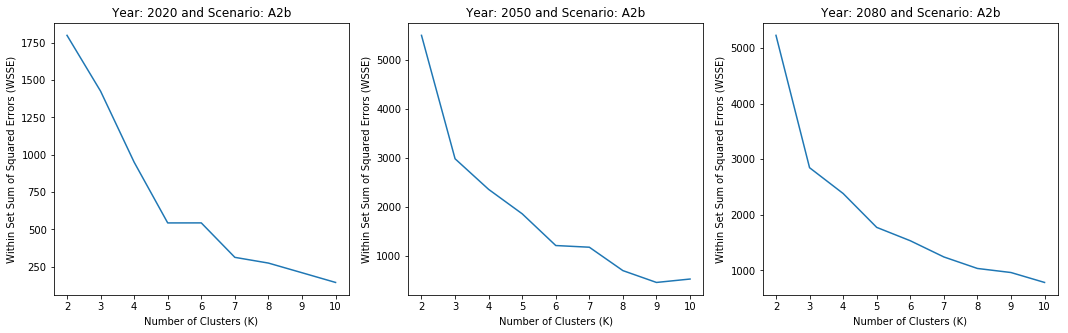

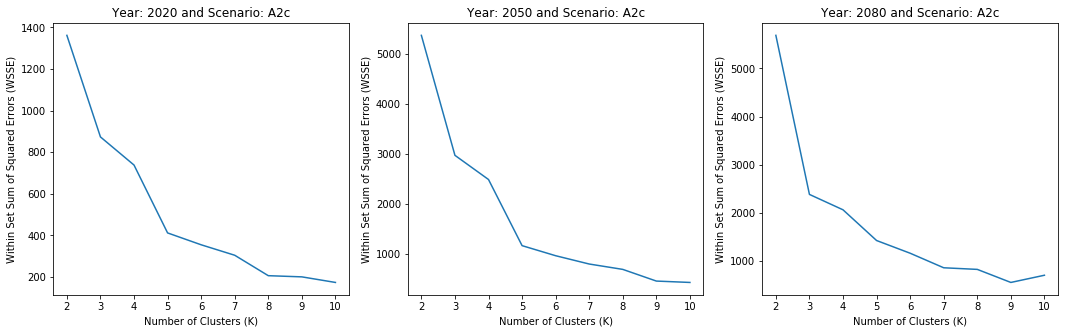

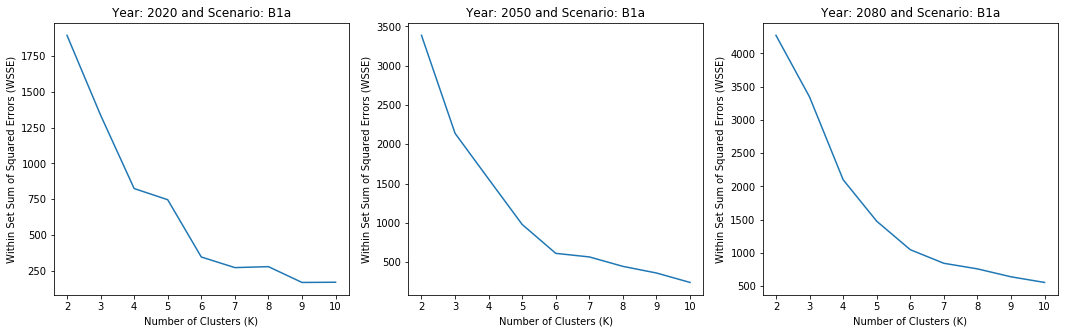

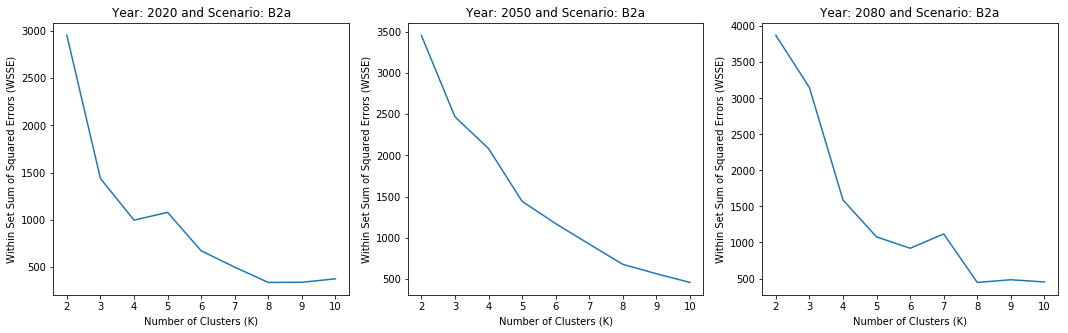

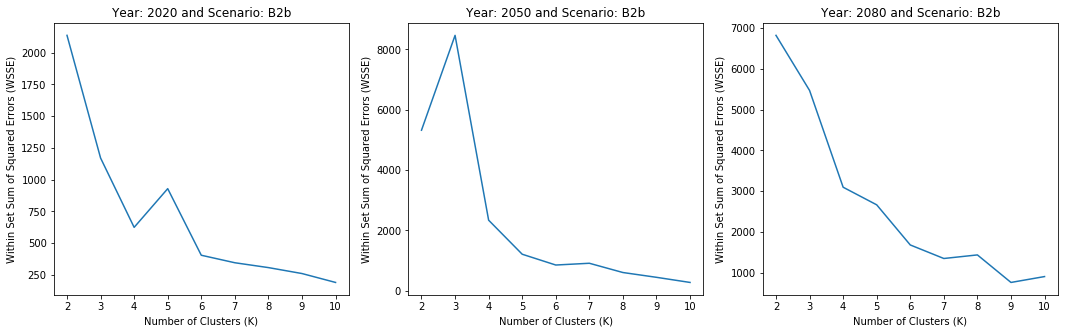

In [9]:
# Train k-Means with k values in [2,10] and calculate WSSSE for each clustering
# Elbow method 


K = list(range(2, 11))
for j in range(0,len(Scenarios)):
    fig, ax = plt.subplots(nrows=1,ncols=3, figsize = (18,5))
    groupScenario = groupYears(scenario=Scenarios[j])
    WSSE_k_year = []
    
    for i in range(0,length):
        groupScenario_values = groupScenario[i].map(lambda x: x[1])
        WSSE_k =[]
        for k in K:
            model_k = KMeans.train(groupScenario_values, k, maxIterations=20)
            WSSE_k.append(model_k.computeCost(groupScenario_values))

        WSSE_k_year.append(WSSE_k)

        # Plot the WSSSE for different values of k

        ax[i].plot(K,WSSE_k_year[i])
        ax[i].set_title('Year: {} and Scenario: {}'.format(Year[i], Scenarios[j]))
        ax[i].set_xlabel('Number of Clusters (K)')
        ax[i].set_ylabel('Within Set Sum of Squared Errors (WSSE)')
    plt.show()
#     plt.clf()
#     plt.figure()

In [10]:
###Storing the best K values for different years and scenarios found from the elbow method
K2020_scenario = [4,5,5,5,6,6,6]
K2050_scenario = [6,5,6,5,6,8,5]
K2080_scenario = [3,8,5,7,7,8,7]

In [11]:
def makeKeyValue(key, value=1):
    return (key, value)
def addValues(val1, val2):
    return val1 + val2

In [25]:
def plotCropClusters(data, cluster_ids):
    # Plot the clusters with a scatter plot
    fig = plt.figure(figsize = (10,7))
    ax = plt.axes(projection='3d')
    data = np.array(data.collect())

    ax.scatter3D(data[:,0],data[:,1],data[:,2], c=cluster_ids, s=20)
#     ax.set_xlim(0, 2e7)
#     ax.set_ylim(0, 1e7)
#     ax.set_zlim(0, 1e7)
  
    ax.set_xlabel('Wheat')
    ax.set_ylabel('Rice')
    ax.set_zlabel('Maize')

    plt.title('Change in yield')
    plt.show()
    plt.clf()
    
def plotClusterCentres(largestCluster,title):
    
    Crop_YieldChange = np.zeros([3,3])
    for i in range(0,3):
        for j in range(0,3):
            Crop_YieldChange[i][j] = largestCluster[j][i]
    cropLabel = ['Wheat','Rice','Maize']
    for i in range(0,length):
        plt.plot(Year,Crop_YieldChange[i],'o',label=cropLabel[i],markersize=8)
        
    plt.title('Cluster Center as a Function of Years (Scenario: {})'.format(title), fontdict=font)
    plt.xlabel('Year', fontdict=font)
    plt.ylabel('Change in yield', fontdict=font)
    plt.legend()
    plt.show()
    plt.clf()
    
    
def clusterAndPlotData(data,Kay2020,Kay2050,Kay2080,vis):
    # Cluster food items using kMeans and input K value
    ########2020##########
    
    Kay = [Kay2020,Kay2050,Kay2080]
    data_values = []
    model = []
    cluster_ids_RDD = []
    cluster_ids = []
    Cluster_keyvalues = []
    Cluster_counts = []
    Cluster_counts_sorted = []
    Cluster_centers = []
    CountryCluster = []
    CountryClusterRDD = []
    sortedCountryClusterRDD = []
    ID_LargestCluster = []
    Center_LargestCluster = []
    Year_ClusterCenter_Pair = []
    
    data_headers = np.array(data[0].map(lambda x: x[0]).collect())
    
    for i in range(0,length):
        data_values.append(data[i].map(lambda x: x[1]))
        model.append(KMeans.train(data_values[i], Kay[i], maxIterations=50, initializationMode='random'))
        cluster_ids_RDD.append(model[i].predict(data_values[i]))
        Cluster_centers.append(model[i].clusterCenters)
        cluster_ids.append(cluster_ids_RDD[i].collect())
        Cluster_keyvalues.append(cluster_ids_RDD[i].map(makeKeyValue))
        Cluster_counts.append(Cluster_keyvalues[i].reduceByKey(addValues))
        Cluster_counts_sorted.append(Cluster_counts[i].top(Kay[i],key=lambda x: x[1]))
#         print(Cluster_counts_sorted[i])
#         print(Cluster_centers[i])
        # Plot crop clusters
        if vis==True:
            plotCropClusters(data_values[i], cluster_ids[i])
        
        
        CountryCluster.append([(cluster_ids[i][j],data_headers[j]) for j in range(0,len(cluster_ids[0]))])
        CountryClusterRDD.append(sc.parallelize(CountryCluster[i]))
        sortedCountryClusterRDD.append(sorted(CountryClusterRDD[i].collect()))
        
        ID_LargestCluster.append(Cluster_counts_sorted[i][0][0])       
        Center_LargestCluster.append(Cluster_centers[i][ID_LargestCluster[i]])
               
        Year_ClusterCenter_Pair.append((Year[i],Center_LargestCluster[i]))

#     print(Center_LargestCluster)
#     print(Cluster_counts_sorted)
#     print(ID_LargestCluster)

#     print(Year_ClusterCenter_Pair)
#     print('Cluster ID : Country')
    
#     for entry in sortedCountryClusterRDD[0]:
#         CID, Country = entry
#         print('{:<10} : {:5s}'.format(CID, Country))

    return Center_LargestCluster

In [26]:
# array = np.zeros([165, 3])
# for i in range(0,165):
#     for j in range(3,6):
#         array[i][j-3] = dataDF.iloc[i, j]

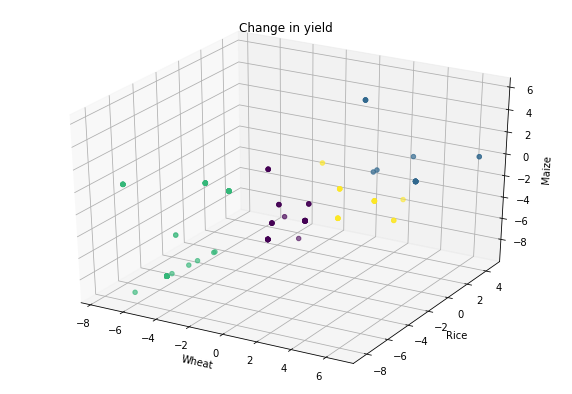

<Figure size 432x288 with 0 Axes>

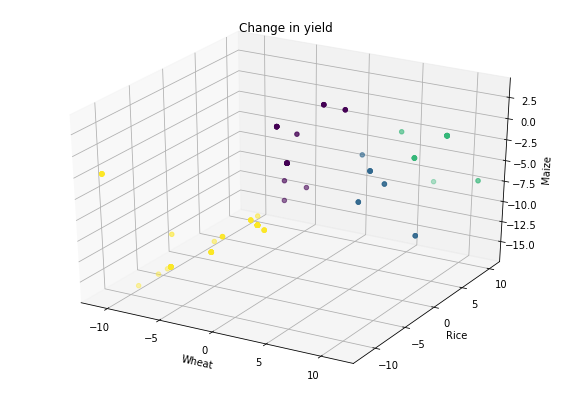

<Figure size 432x288 with 0 Axes>

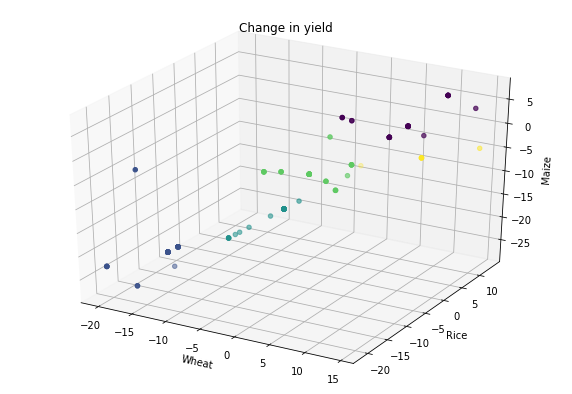

[array([-0.63991899, -2.09216291, -4.1950922 ]),
 array([ -4.32500993,  -5.32500993, -11.29946737]),
 array([-15.07847055, -16.07847055, -20.89701113])]

<Figure size 432x288 with 0 Axes>

In [27]:
clusterAndPlotData(groupTest,Kay2020=5,Kay2050=4,Kay2080=7,vis=True)

In [22]:
CLCentres_scenario = []
for i in range(0,len(Scenarios)):
    print('Scenario: {}'.format(Scenarios[i]))
    CLCentres_scenario.append(clusterAndPlotData(groupYears(scenario=Scenarios[i]),Kay2020=K2020_scenario[i],Kay2050=K2050_scenario[i],Kay2080=K2080_scenario[i],vis=False))

Scenario: A1F
Scenario: A2a
Scenario: A2b
Scenario: A2c
Scenario: B1a
Scenario: B2a
Scenario: B2b


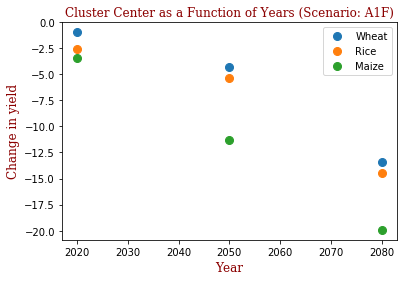

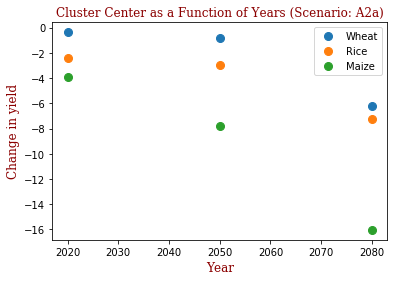

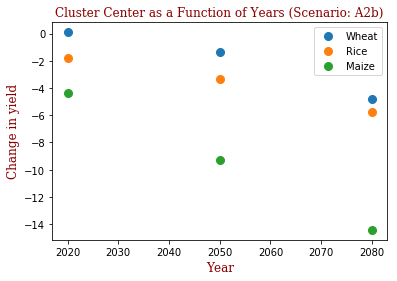

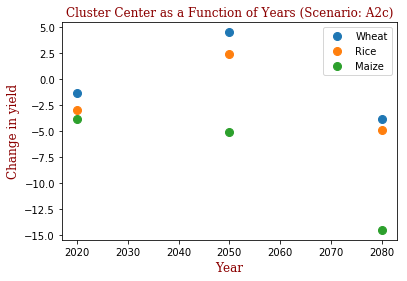

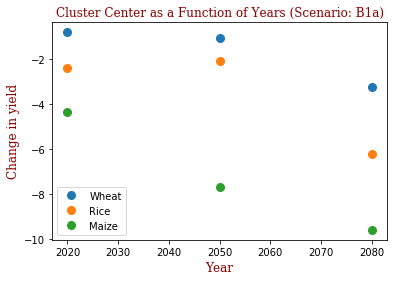

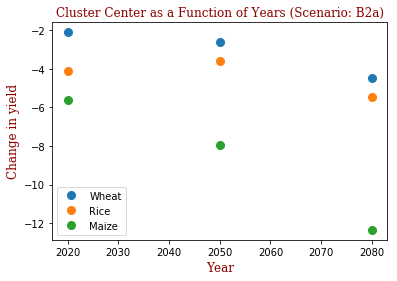

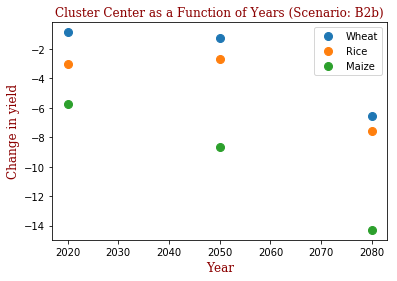

<Figure size 432x288 with 0 Axes>

In [23]:
for i in range(0,len(Scenarios)):
    plotClusterCentres(CLCentres_scenario[i],title=Scenarios[i])

# DBSCAN

---

Clustering using DBSCAN

In [28]:
from src.DBSCAN import DBSCAN
# Define DBSCAN parameters
epsilon = 1
min_pts = 4
metric = 'euclidean'

# Cluster the countries with DBSCAN

country_clusters = []

for i in range(0,length):
    print('Year: {}'.format(Year[i]))
    country_clusters.append(DBSCAN(sc, groupTest[i], epsilon=epsilon, minpts=min_pts, metric=metric))
    # Look at the cluster results
    # Elements in the RDD are key-value pairs of (food ID, cluster ID)
    print('Clustered crops: {}'.format(country_clusters[i].count()))
    print(country_clusters[i].take(1))

Year: 2020
DBSCAN completed in 1 iterations
Clustered crops: 142
[('Iraq', 'Afghanistan')]
Year: 2050
DBSCAN completed in 3 iterations
Clustered crops: 144
[('Iraq', 'Afghanistan')]
Year: 2080
DBSCAN completed in 1 iterations
Clustered crops: 140
[('Iraq', 'Afghanistan')]


In [29]:
# Define a function to report the percent of total food items that are clustered
# The input 'clusters' should be the output of DBSCAN
# The input 'total' should be the total number of unique food items (before clustering)
# HINT: ref [2]
def percentClustered(clusters, total):
    return (clusters.count()/total)*100

    
# Define a function to count the number of clusters
# The input 'clusters' should be the output of DBSCAN
# HINT: ref [2,3]
def clusterCount(clusters):
    return clusters.map(lambda x:x[1]).distinct().count()

In [30]:
# Apply the functions you defined to the clusters found above
perc_clust = []
clust_cnt = []
for i in range(0,length):
    print('Year: {}'.format(Year[i]))
    perc_clust.append(percentClustered(country_clusters[i], groupTest[i].count()))
    clust_cnt.append(clusterCount(country_clusters[i]))

    # Print results
    # print(food_clusters.count())
    # print(clean_data.count())
    print('Countries clustered: {:.2f}%'.format(perc_clust[i]))
    print('Number of country clusters: {}'.format(clust_cnt[i])) 


Year: 2020
Countries clustered: 86.06%
Number of country clusters: 14
Year: 2050
Countries clustered: 87.27%
Number of country clusters: 12
Year: 2080
Countries clustered: 84.85%
Number of country clusters: 14


In [31]:
import matplotlib as mpl

# Define a function that intake a 2D array of data values and plots a heatmap
# Make sure you include axes and tick labels as well as a color bar!
# HINT: ref [1,2,3]
def plotHeatMap(data, x_title='X Axis', y_title='Y Axis', title='', x_ticks=[], y_ticks=[]):
    heatmap = plt.pcolor(data)
    plt.title(title)
    plt.xlabel(x_title)
    plt.ylabel(y_title)
    plt.xticks(np.arange(len(x_ticks))+0.5, x_ticks)
    plt.yticks(np.arange(len(y_ticks))+0.5, y_ticks)
    plt.colorbar()
    return heatmap

In [32]:
def plotClusterCounts(data,eps2020,minPts2020,eps2050,minPts2050,eps2080,minPts2080,marker,msize,lab):
    eps_array = [eps2020,eps2050,eps2080]
    minPts_array = [minPts2020,minPts2050,minPts2080]
    clusters_array = []
    clusterCount_array = []
    for i in range(0,length):
        clusters_array.append(DBSCAN(sc, data[i], epsilon=eps_array[i], minpts=minPts_array[i], metric=metric))
        clusterCount_array.append(clusterCount(clusters_array[i]))
        
    plt.plot(Year,clusterCount_array,marker,label=lab,markersize=msize,markerfacecolor='none')
    plt.title('Number of Clusters as a Function of Years', fontdict=font)
    plt.xlabel('Year', fontdict=font)
    plt.ylabel('Number of Clusters', fontdict=font)
#     plt.show()
#     plt.clf()

In [33]:
# Define the distance metric we want to use
metric = 'euclidean'

# Test each combination of epsilon and minpts value in the ranges defined above!
# Fill each of the numpy arrays below with the correct values for epsilon i and min_pts j
# For example, when epsilon is 4 and min_pts is 5, enter values in array location [2,1]

eps = list(range(2,5))
minPts = list(range(4,8))

hm_per_data = np.zeros((3, 4))
hm_count_data = np.zeros((3, 4))

# Created nested for loops to enumerate each combination of epsilon and min_pts value
# Record the percentage of food items clustered and the number of clusters
# We reccommend you use print statements to see the progress!
for l in range(0,length):
    print('Year: {}'.format(Year[l]))
    testData = groupTest[l]
    for i in range(0,len(eps)):
        for j in range(0,len(minPts)):
            clustersLoop = DBSCAN(sc, testData, epsilon=eps[i], minpts=minPts[j], metric=metric)
            hm_per_data[i,j] = percentClustered(clustersLoop, testData.count())
            hm_count_data[i,j] = clusterCount(clustersLoop)

            print(eps[i],minPts[j],hm_per_data[i,j],hm_count_data[i,j])

Year: 2020
DBSCAN completed in 4 iterations
2 4 93.33333333333333 8.0
DBSCAN completed in 4 iterations
2 5 86.06060606060606 5.0
DBSCAN completed in 4 iterations
2 6 83.03030303030303 4.0
DBSCAN completed in 4 iterations
2 7 83.03030303030303 4.0
DBSCAN completed in 5 iterations
3 4 96.36363636363636 4.0
DBSCAN completed in 5 iterations
3 5 91.51515151515152 2.0
DBSCAN completed in 5 iterations
3 6 91.51515151515152 2.0
DBSCAN completed in 5 iterations
3 7 91.51515151515152 2.0
DBSCAN completed in 4 iterations
4 4 97.57575757575758 3.0
DBSCAN completed in 4 iterations
4 5 92.72727272727272 1.0
DBSCAN completed in 4 iterations
4 6 92.72727272727272 1.0
DBSCAN completed in 4 iterations
4 7 92.72727272727272 1.0
Year: 2050
DBSCAN completed in 2 iterations
2 4 90.30303030303031 12.0
DBSCAN completed in 2 iterations
2 5 83.03030303030303 9.0
DBSCAN completed in 2 iterations
2 6 76.96969696969697 7.0
DBSCAN completed in 2 iterations
2 7 73.33333333333333 6.0
DBSCAN completed in 6 iterations


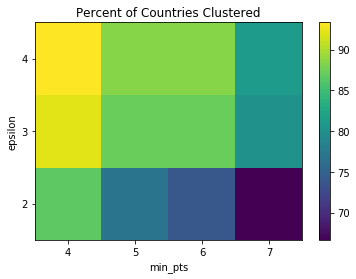

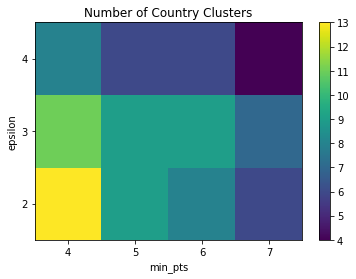

In [34]:
# Plot the results in heatmaps
plotHeatMap(hm_per_data, y_title='epsilon', x_title='min_pts',\
            title='Percent of Countries Clustered', y_ticks=range(2,5), x_ticks=range(4,8))
plt.figure()
plotHeatMap(hm_count_data, y_title='epsilon', x_title='min_pts',\
            title='Number of Country Clusters', y_ticks=range(2,5), x_ticks=range(4,8))  

DBSCAN completed in 3 iterations
DBSCAN completed in 2 iterations
DBSCAN completed in 3 iterations


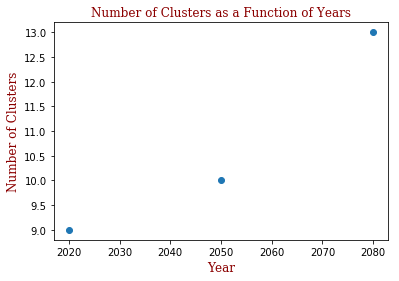

<Figure size 432x288 with 0 Axes>

In [20]:
plotClusterCounts(groupTest,eps2020=2,minPts2020=4,eps2050=2,minPts2050=4,eps2080=2,minPts2080=4,marker='o')

In [35]:
def plotFoodClusters3D(clusters):
    cluster_ids = clusters.keys().collect()
    unique_ids = np.unique(cluster_ids).tolist()
    cluster_ids = [unique_ids.index(i) for i in cluster_ids]
    
    yieldChange_values = clusters.values().collect()
    
    # Plot clusters'
    X = []
    Y = []
    Z = []
    for i in range(0,len(yieldChange_values)):
        X.append(yieldChange_values[i][0])
        Y.append(yieldChange_values[i][1])
        Z.append(yieldChange_values[i][2])
    
    fig = plt.figure(figsize = (10,7))
    ax = plt.axes(projection='3d')

    ax.scatter3D(X,Y,Z, c=cluster_ids, s=20)
#     ax.set_xlim(0, 2e7)
#     ax.set_ylim(0, 1e7)
#     ax.set_zlim(0, 1e7)
  
    ax.set_xlabel('Wheat', fontdict=font)
    ax.set_ylabel('Rice', fontdict=font)
    ax.set_zlabel('Maize', fontdict=font)

    plt.title('Change in yield', fontdict=font)
    plt.show()
    plt.clf()

DBSCAN completed in 1 iterations


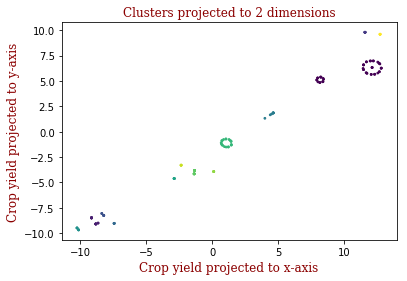

<Figure size 432x288 with 0 Axes>

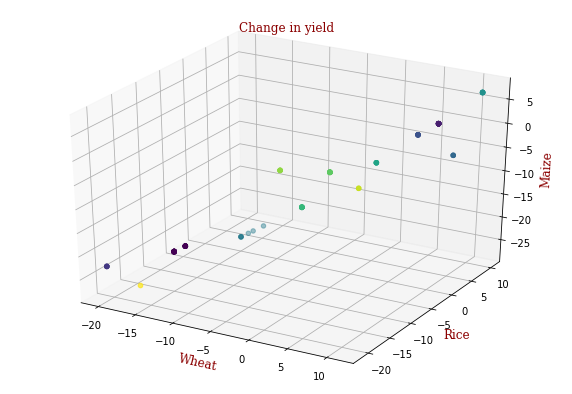

13 Clusters found with 86.67 % food items clustered


<Figure size 432x288 with 0 Axes>

In [36]:
from sklearn.manifold import TSNE

# Projects and plots high dimensional food clusters to a 2D axis
# Input: clusters: RDD <<(cluster ID, [nutrient, values]), (cluster ID, [nutrient, values]), ...>>
# Return: None (shows a plot)
def plotFoodClusters2D(clusters):
    # Get cluster IDS to color plotted clusters
    cluster_ids = clusters.keys().collect()
    unique_ids = np.unique(cluster_ids).tolist()
    cluster_ids = [unique_ids.index(i) for i in cluster_ids]
    
    # Reduce nutrient values to 2 dimensions with TSNE
    # HINT: ref [1,2]
    yield_values = clusters.values().collect()
    cluster_embedded = TSNE(n_components=2).fit_transform(yield_values)
    
    # Plot clusters
    X = cluster_embedded[:,0]
    Y = cluster_embedded[:,1]
    plt.scatter(X, Y, c=cluster_ids, s=3)
    plt.title('Clusters projected to 2 dimensions', fontdict=font)
    plt.xlabel('Crop yield projected to x-axis', fontdict=font)
    plt.ylabel('Crop yield projected to y-axis', fontdict=font)
    plt.show()
    plt.clf()
    
    
# Define your values for epsilon and min_pts
epsilon = 2
min_pts = 4
metric = 'euclidean'

# Cluster the food items with your parameters and DBSCAN
country_clusters = DBSCAN(sc, testData, epsilon=epsilon, minpts=min_pts, metric=metric)

# Combine cluster ID with nutrient value
# RDD is now << (food ID, (cluster ID, [nutrient, values])), (food ID, (cluster ID, [nutrient, values])), ...>>
cluster_data = country_clusters.join(testData)

# Isolate cluster ID and nutrient value (i.e., get rid of food item ID)
# RDD should be <<(cluster ID, [nutrient, values]), (cluster ID, [nutrient, values]), ...>>
cluster_yield = cluster_data.values()

# Plot clusters in 2D projected space and report cluster information
plotFoodClusters2D(cluster_yield)
plotFoodClusters3D(cluster_yield)
perc_clust = percentClustered(country_clusters, testData.count())
clust_cnt = clusterCount(country_clusters)
print('{} Clusters found with {:.2f} % food items clustered'.format(clust_cnt, perc_clust))

In [23]:
print(food_clusters.take(1))

[('Ethiopia', 'Afghanistan')]


Scenario: A1F
DBSCAN completed in 4 iterations
DBSCAN completed in 2 iterations
DBSCAN completed in 1 iterations
Scenario: A2a
DBSCAN completed in 3 iterations
DBSCAN completed in 2 iterations
DBSCAN completed in 3 iterations
Scenario: A2b
DBSCAN completed in 5 iterations
DBSCAN completed in 4 iterations
DBSCAN completed in 3 iterations
Scenario: A2c
DBSCAN completed in 5 iterations
DBSCAN completed in 3 iterations
DBSCAN completed in 5 iterations
Scenario: B1a
DBSCAN completed in 3 iterations
DBSCAN completed in 3 iterations
DBSCAN completed in 4 iterations
Scenario: B2a
DBSCAN completed in 3 iterations
DBSCAN completed in 4 iterations
DBSCAN completed in 2 iterations
Scenario: B2b
DBSCAN completed in 10 iterations
DBSCAN completed in 3 iterations
DBSCAN completed in 2 iterations


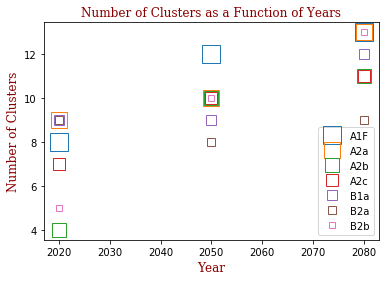

In [38]:
####################### DBSCAN clustering for all the seven scenarios#############################
####Plotting the number of clusters vs. years for all the scenarios in a single plot#####
Data_scenario = []
plt.figure()
for i in range(0,len(Scenarios)):
    print('Scenario: {}'.format(Scenarios[i]))
    Data_scenario.append(groupYears(scenario=Scenarios[i]))#Scenarios A1F, A2a, A2b, A2c, B1a, B2a, B2b
    plotClusterCounts(Data_scenario[i],eps2020=2,minPts2020=4,eps2050=2,minPts2050=4,eps2080=2,minPts2080=4,marker='s',msize=18-2*i,lab=Scenarios[i])
plt.legend()
plt.show()   

In [40]:
# Stop the Spark Context
sc.stop()